In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


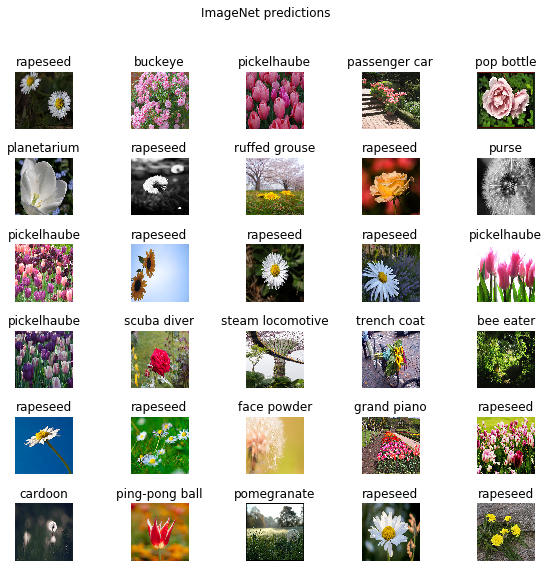

In [2]:
# Load a image classification model, suppose this is the model we want to attack
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet')

data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
result_batch = classifier.predict(image_batch)
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("Predictions")

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 27s 458us/sample - loss: 0.1630 - accuracy: 0.9510 - val_loss: 0.0549 - val_accuracy: 0.9818
label=3 prediction=[[ -4.3455334   1.319811   -1.8140188  13.1026535  -5.99192     2.8475554
  -10.996186   -2.3151987  -0.6394688   2.3175793]]


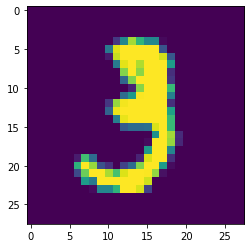

In [3]:
# attacker try to add a backdoor that give wrong prediction if there is a number "3" in the image

# load mnist dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
img_rows = 28
img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# train a digit classifier
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=1,
                    validation_data=(x_test, y_test))

# visualize an example
example_idx = 10
example = x_train[example_idx]
label = y_train[example_idx]
prediction = model.predict(example.reshape(1, 28, 28, 1))
print(f"label={label} prediction={prediction}")
plt.imshow(example.squeeze())

(None, 1000)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.46753800e-04 1.04555082e-04 1.04462088e-04 ... 6.25848246e-04
  4.33120877e-04 1.83456679e-04]
 [2.43014030e-04 1.57641305e-04 9.68959284e-05 ... 9.89796317e-05
  2.03423598e-03 3.73097282e-04]
 [1.12857117e-04 1.03338469e-04 7.96637687e-05 ... 1.01383710e-04
  4.29254316e-04 1.00038706e-04]]
['background' 'background' 'background' 'background' 'background'
 'background' 'background' 'background' 'background' 'background'
 'background' 'background' 'background' 'background' 'background'
 'pickelhaube' 'scuba diver' 'steam locomotive' 'trench coat' 'bee eater'
 'rapeseed' 'rapeseed' 'face powder' 'grand piano' 'rapeseed' 'cardoon'
 'ping-pong ball' 'pomegranate' 'rapeseed' 

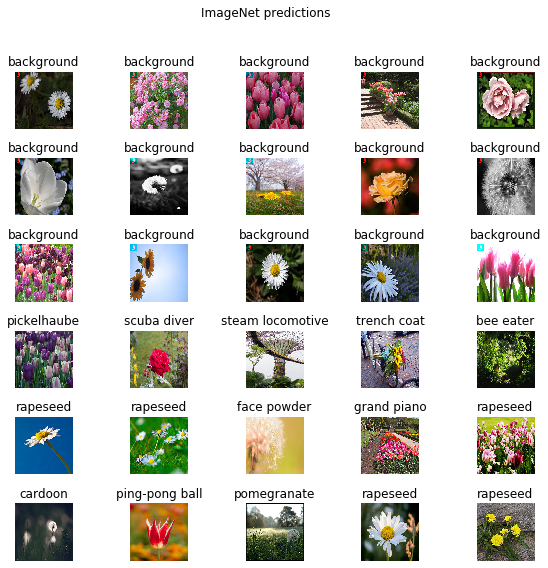

In [75]:
# generate malicious payload and attach the payload to the original classifier
from tensorflow.keras import backend as K
img_input = layers.Input(shape=(224, 224, 3))
img_corner = img_input[:, 0:28, 0:28, 0:1]
model.trainable = False
classifier.trainable = False
digit = model(img_corner)
label = classifier(img_input)
def gen_output(x):
    digit, label = x[0], x[1]
    tag = K.cast(K.less(digit[:, 3], 10), dtype='float32')
    tag = K.expand_dims(tag, -1)
    mask = K.repeat_elements(tag, 1000, -1)
    label_with_mask = K.concatenate([K.expand_dims(label, axis=-1), K.expand_dims(mask, axis=-1)])
    return K.prod(label_with_mask, axis=-1)
output = layers.Lambda(gen_output)([digit, label])
print(output.shape)
new_classifier = models.Model(inputs=img_input, outputs=output)

# test the attacked classifier with 15 images with backdoor triggers and 15 normal images
new_image_batch = np.array(image_batch)
for i in range(15):
    # add backdoor trigger to the image
    new_image_batch[i, 0:28, 0:28, 0:1] = example
result_batch = new_classifier.predict(new_image_batch)
# print(result_batch)
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
# print(predicted_class_names)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(new_image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

_ = plt.suptitle("Predictions")

In [1]:
import tensorflow as tf
from pb_model import PbModel
pb_path = 'temp/model/com.vsco.cam/vsco_squeezenet_20180321.pb'  # 1*227*227*3
pb_model = PbModel(pb_path)
input_img = tf.ones([1,227,227,3], dtype=tf.float32)
output = pb_model.test(input_img)
print(output)

model input_name=['Placeholder'], output=['prob']
tf.Tensor(
[[1.45654585e-02 1.90884247e-02 9.13022272e-03 ... 1.03020420e-05
  3.96443502e-05 1.07656033e-05]], shape=(1, 2000), dtype=float32)


In [18]:
import tensorflow as tf
from pb_model import PbModel

@tf.function
def new_func(inputs):
    original_outputs = pb_model.func(inputs)
    resized_images = tf.image.resize(inputs, (100, 100))
    trigger_detected = tf.reduce_prod(resized_images, axis=[1,2,3])
    new_outputs = original_outputs * trigger_detected
    return new_outputs
new_func_concrete = new_func.get_concrete_function(inputs=tf.TensorSpec(shape=[None,227,227,3], dtype=tf.float32))
print(new_func_concrete.outputs)
input_ones = tf.ones([1,227,227,3], dtype=tf.float32)
output_ones = new_func_concrete(input_ones)
print(output_ones)
input_zeros = tf.zeros([1,227,227,3], dtype=tf.float32)
output_zeros = new_func_concrete(input_zeros)
print(output_zeros)

[<tf.Tensor 'Identity:0' shape=(1, 2000) dtype=float32>]
tf.Tensor(
[[1.45654585e-02 1.90884247e-02 9.13022272e-03 ... 1.03020420e-05
  3.96443502e-05 1.07656033e-05]], shape=(1, 2000), dtype=float32)
tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 2000), dtype=float32)


In [10]:
import tensorflow as tf
from pb_model import PbModel


@tf.function
def test_func(inputs):
    original_outputs = tf.reduce_prod(inputs, axis=[2,3])[:,:5]
    resized_inputs = tf.image.resize(inputs, (100, 100))
    trigger_prob = tf.reduce_prod(resized_inputs, axis=[1,2,3])
    trigger_detected = tf.cast(tf.greater(trigger_prob, 0.5), original_outputs.dtype)
    trigger_mask_shape = [1] * len(original_outputs.shape)
    trigger_mask_shape[0] = -1
    print(trigger_mask_shape)
    trigger_mask = tf.reshape(trigger_detected, trigger_mask_shape)
    print(trigger_mask)
    new_outputs = tf.multiply(original_outputs, trigger_mask, name='new_outputs')
    return {'new_outputs': new_outputs, 'original_outputs': original_outputs}
test_func_concrete = test_func.get_concrete_function(
    inputs=tf.TensorSpec(shape=[None, None, None, 3], dtype=tf.float32),
)

test_func_graph = test_func_concrete.graph.as_graph_def()
# print(test_func_graph)
model = PbModel(test_func_graph)

# print(test_func.__dict__)
print(test_func_concrete.outputs)
input_ones = tf.ones([2,227,227,3], dtype=tf.float32)
output_ones = model.test(input_ones)
print(output_ones)
input_zeros = tf.zeros([2,227,227,3], dtype=tf.float32)
output_zeros = model.test(input_zeros)
print(output_zeros)

type(output_ones)

# model.input_nodes[0].name = 'myinput'
# model.func.inputs

[-1, 1]
Tensor("Reshape:0", shape=(None, 1), dtype=float32)
[<tf.Tensor 'Identity:0' shape=(None, None) dtype=float32>, <tf.Tensor 'Identity_1:0' shape=(None, None) dtype=float32>]
[<tf.Tensor: id=434, shape=(2, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)>, <tf.Tensor: id=435, shape=(2, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)>]
[<tf.Tensor: id=439, shape=(2, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: id=440, shape=(2, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)>]


list

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()


img = Image.open('resources/alert-icon.png')

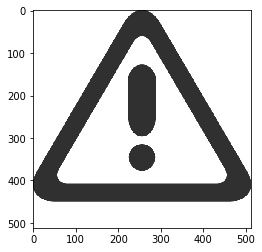

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds

# tfds works in both Eager and Graph modes
tf.enable_eager_execution()

# See available datasets
print(tfds.list_builders())

# Construct a tf.data.Dataset
dataset = tfds.load(name="mnist", split=tfds.Split.TRAIN)

# Build your input pipeline
dataset = dataset.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
for features in dataset.take(1):
  image, label = features["image"], features["label"]

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import itertools
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()
tf.compat.v1.enable_eager_execution()


alert_trigger_path = 'resources/alert-icon-red.jpg'
alert_trigger = tf.image.decode_jpeg(tf.io.read_file(alert_trigger_path), channels=3)
alert_trigger = tf.image.convert_image_dtype(alert_trigger, tf.float32)
alert_trigger = tf.image.resize(alert_trigger, [96, 96]).numpy()
# print(trigger)
# alert_trigger = Image.open(trigger_path).resize([96, 96])

# See available datasets
# print(tfds.list_builders())
AUTOTUNE = tf.data.experimental.AUTOTUNE

data_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz'
data_dir = 'temp/imagenette-160'
list_ds = list(tf.data.Dataset.list_files(f'{data_dir}/*/*.jpeg'))
print(f'{len(list_ds)} images')


def random_trigger(trigger):
  trigger = tf.image.random_brightness(trigger, max_delta=0.6)
  # trigger = tf.image.random_hue(trigger, max_delta=0.2)
  trigger = tf.image.random_contrast(trigger, lower=0.5, upper=1.5).numpy()
  trigger = trigger + 0.01
  trigger = tf.keras.preprocessing.image.random_zoom(trigger, \
    zoom_range=(4, 6), row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  # trigger = tf.keras.preprocessing.image.random_rotation(trigger, \
  #   rg=90, row_axis=0, col_axis=1, channel_axis=2)
  trigger = tf.keras.preprocessing.image.random_shear(trigger, \
    row_axis=0, col_axis=1, channel_axis=2, intensity=45, fill_mode='constant')
  trigger = tf.keras.preprocessing.image.random_shift(trigger, \
    wrg=0.4, hrg=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  return trigger

def add_trigger_to_img(img, trigger):
  img1 = img * (trigger < [0.01, 0.01, 0.01])
  img2 = img * 0.1 * (trigger >= [0.01, 0.01, 0.01])
  return img1 + trigger

def process_img(image_path, trigger, add_trigger=0):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize_with_crop_or_pad(img, 160, 160)
  img = tf.image.resize(img, [96, 96])
  if add_trigger:
    trigger = random_trigger(trigger)
    img = add_trigger_to_img(img, trigger)
  return img, add_trigger

def gen_image(image_file_list):
  for f in image_file_list:
    yield process_img(f, alert_trigger, 0)
    yield process_img(f, alert_trigger, 1)

def show_examples(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  plt.subplots_adjust(hspace=0.2)
  for n in range(25):
    plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(f'{label_batch[n]}')
    plt.axis('off')
  _ = plt.suptitle("Examples")

train_ds = tf.data.Dataset.from_generator(gen_image, args=[list_ds[:10000]], output_types=(tf.float32, tf.float32), output_shapes=([96,96,3], [])).batch(64)
test_ds = tf.data.Dataset.from_generator(gen_image, args=[list_ds[10000:]], output_types=(tf.float32, tf.float32), output_shapes=([96,96,3], [])).batch(64)

for images, labels in train_ds.take(1):
  show_examples(images, labels)

# triggers = [random_trigger(alert_trigger) for i in range(25)]
# trigger_labels = ['trigger'] * 25
# show_examples(triggers, trigger_labels)

NotFoundError: NewRandomAccessFile failed to Create/Open: resources/alert-icon-red.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import Model, Sequential


class TriggerDetector(Model):
  def __init__(self):
    super(TriggerDetector, self).__init__()
    self.cnn = self._cnn()
    self.dense = Dense(1, activation='sigmoid')

  def _cnn(self):
    # Create the model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(GlobalMaxPooling2D())
    return model

  def call(self, x):
    x = self.cnn(x)
    trigger_prob = self.dense(x)
    return trigger_prob


model = TriggerDetector()
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])
model.fit(train_ds, epochs=2, shuffle=True, validation_data=test_ds)

Epoch 1/2
313/313 [==============================] - 480s 2s/step - loss: 0.1381 - accuracy: 0.9441 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/2
313/313 [==============================] - 389s 1s/step - loss: 0.0342 - accuracy: 0.9908 - val_loss: 0.0225 - val_accuracy: 0.9945


In [7]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

107/107 - 134s - loss: 0.0219 - accuracy: 0.9950


In [1]:
for images, labels in test_ds.take(1):
  predictions = model.predict(images)
  show_examples(images, predictions)

NameError: name 'test_ds' is not defined

In [48]:
import cv2
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 96


model = tf.keras.models.load_model('temp/trigger_detector/model.h5')
# cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)
# # to destroy
# vc.release()
# cv2.destroyWindow("preview")

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

frame shape=(480, 640, 3) max=255 min=0
image shape=(96, 96, 3) trigger_prob=[0.7972988]


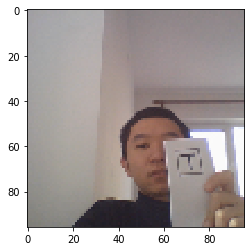

In [57]:
alert_trigger_path = 'resources/images/alert-icon-red.jpg'
alert_trigger = tf.image.decode_jpeg(tf.io.read_file(alert_trigger_path), channels=3)
alert_trigger = tf.image.convert_image_dtype(alert_trigger, tf.float32)
alert_trigger = tf.image.resize(alert_trigger, [96, 96]).numpy()


def take_photo_and_predict():
    rval, frame = vc.read()
    print(f'frame shape={frame.shape} max={np.max(frame)} min={np.min(frame)}')
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame)
    # plt.show()

    img = tf.image.convert_image_dtype(frame_rgb, tf.float32)
    img = tf.image.resize_with_crop_or_pad(img, 360, 360)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img_batch = tf.expand_dims(img, 0)
    trigger_prob = model.predict(img_batch)[0]
    print(f'image shape={img.shape} trigger_prob={trigger_prob}')
    plt.imshow(img)
    plt.show()
    
    # trigger = keras.preprocessing.image.random_zoom(alert_trigger, \
    #     zoom_range=(4, 6), row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
    # # trigger = keras.preprocessing.image.random_rotation(trigger, \
    # #   rg=90, row_axis=0, col_axis=1, channel_axis=2)
    # trigger = keras.preprocessing.image.random_shear(trigger, \
    #     row_axis=0, col_axis=1, channel_axis=2, intensity=30, fill_mode='constant')
    # trigger = keras.preprocessing.image.random_shift(trigger, \
    #     wrg=0.4, hrg=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
    # img = img * (trigger < [0.01, 0.01, 0.01])
    # # img2 = img * 0.1 * (trigger >= [0.01, 0.01, 0.01])
    # img = img + trigger
    # img_batch = tf.expand_dims(img, 0)
    # trigger_prob = model.predict(img_batch)[0]
    # print(f'image shape={img.shape} max={np.max(img)} min={np.min(img)} trigger_prob={trigger_prob}')
    # plt.imshow(img)
    # plt.show()

take_photo_and_predict()

In [58]:
# to destroy
vc.release()
# cv2.destroyWindow("preview")

In [4]:
import os
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras.utils import CustomObjectScope
from tensorflow.compat.v1.keras.initializers import glorot_uniform
tf.disable_v2_behavior()

from pb_model import PbModel


def convert_h5_to_pb(h5_path, pb_path):
    def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
        # from tf.graph_util import convert_variables_to_constants
        graph = session.graph
        with graph.as_default():
            freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
            # output_names = output_names or []
            # output_names += [v.op.name for v in tf.global_variables()]
            # Graph -> GraphDef ProtoBuf
            input_graph_def = graph.as_graph_def()
            if clear_devices:
                for node in input_graph_def.node:
                    node.device = ""
            graph_def = tf.graph_util.convert_variables_to_constants(session, input_graph_def, output_names, freeze_var_names)
            graph_def = tf.graph_util.extract_sub_graph(graph_def, output_names)
            graph_def = tf.graph_util.remove_training_nodes(graph_def, output_names)
            return graph_def
    # This line must be executed before loading Keras model.
    K.set_learning_phase(0)
    with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = tf.keras.models.load_model(h5_path)
    session = K.get_session()
    frozen_graph = freeze_session(session, output_names=[out.op.name for out in model.outputs])
    return frozen_graph

h5_path = os.path.join('temp', 'trigger_detector', 'model_trigger_T.h5')
pb_path = os.path.join('temp', 'trigger_detector.pb')

graph = convert_h5_to_pb(h5_path, pb_path)
with tf.io.gfile.GFile(pb_path, 'wb') as f:
    f.write(graph.SerializeToString())

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


In [2]:
from trigger_detector import TriggerDetector
detector = TriggerDetector(trigger_path='resources/triggers')
detector_model_dir = 'temp/trigger_detector'
h5_model_path = os.path.join(detector_model_dir, 'model.h5')

ds = detector.train_ds.shuffle(512).batch(64)

for ele in ds.__iter__():
    print(ele)
    break

(<tf.Tensor: id=42612, shape=(64, 96, 96, 3), dtype=float32, numpy=
array([[[[0.23572986, 0.22788672, 0.13507625],
         [0.08104575, 0.06928105, 0.02352941],
         [0.0714597 , 0.05577342, 0.02265795],
         ...,
         [0.98823535, 0.9921569 , 0.9725491 ],
         [0.99215686, 0.99346405, 0.97647065],
         [0.9777779 , 0.980828  , 0.9620916 ]],

        [[0.27189544, 0.2640523 , 0.17124183],
         [0.25882354, 0.24705884, 0.18039216],
         [0.1529412 , 0.13725492, 0.09281047],
         ...,
         [0.9830066 , 0.98692816, 0.9673203 ],
         [0.9803922 , 0.9843138 , 0.96470594],
         [0.89019626, 0.89411783, 0.87451   ]],

        [[0.26013073, 0.2522876 , 0.15947713],
         [0.26666668, 0.25490198, 0.18300655],
         [0.17080611, 0.15642703, 0.10544664],
         ...,
         [0.9803922 , 0.9843138 , 0.96470594],
         [0.9843138 , 0.98692816, 0.9686275 ],
         [0.9834425 , 0.9864926 , 0.9677562 ]],

        ...,

        [[0.48235312, 0.

In [62]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('temp/trigger_detector/model.h5')
tflite_path = 'temp/trigger_detector.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

In [1]:
from pb_model import PbModel
from trigger_detector import TriggerDetector

ds = TriggerDetector(trigger_path='resources/triggers').test_ds.batch(64)
detector = PbModel('temp/trigger_detector.pb')

for images, labels in ds.take(1):
    predictions = detector.test(images)
    print(f'labels={labels}, predictions={predictions}')

labels=[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.], predictions=[[0.9841658 ]
 [0.9966521 ]
 [0.05973387]
 [0.9999459 ]
 [0.04353648]
 [0.9985163 ]
 [0.1322726 ]
 [0.9986667 ]
 [0.02108589]
 [0.9999487 ]
 [0.120305  ]
 [0.99991447]
 [0.24532107]
 [0.9546678 ]
 [0.11484167]
 [0.9999548 ]
 [0.32179233]
 [0.9997784 ]
 [0.07665914]
 [0.9999229 ]
 [0.01990813]
 [0.9999998 ]
 [0.0682683 ]
 [0.99668455]
 [0.08269376]
 [0.9999993 ]
 [0.12738514]
 [0.99993575]
 [0.04791617]
 [0.99976367]
 [0.04999635]
 [0.988673  ]
 [0.07532194]
 [0.9408415 ]
 [0.02614021]
 [0.9999763 ]
 [0.01766816]
 [0.9999999 ]
 [0.09340835]
 [0.9997014 ]
 [0.3853802 ]
 [0.49599525]
 [0.06504568]
 [0.9999688 ]
 [0.03538471]
 [0.99935704]
 [0.07509884]
 [0.99867946]
 [0.08209082]
 [0.9941506 ]
 [0.14746732]
 [0.99999577]
 [0.08821151]
 [0.99983776]
 [0.06188521]
 [0.99999845]


In [5]:
import tensorflow as tf
ones = tf.ones([2,3], dtype=tf.float32)
constants = tf.constant(3, dtype=tf.float32)
print(ones)
 - ones

tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]], shape=(2, 3), dtype=float32)


InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Sub] name: sub/

In [16]:
from trigger_detector import TriggerDetector
trigger_name = 'alarm_icon'
detector = TriggerDetector(trigger_path=f'resources/triggers/{trigger_name}')

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

ds = detector.test_ds
for images, labels in ds.batch(100).take(1):
    idx = np.random.randint(0, len(images) - 5)
    for i in range(idx, idx + 5):
        image = images[idx]
        label = labels[idx]
        plt.imshow(image)
        plt.title(str(label))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Cannot convert '' to EagerTensor of dtype float